In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.plotting import plot_connectome
import warnings

warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

src_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)

from connectomics.atlases import fetch_dk_atlas
from connectomics.connectivity import merge_connectomes
from imageproc.dwi._tractseg import QC
from utils.transform import mean_nonzero
from analysis.stats import ols_comparison, ols_matrix_comparison
from analysis.misc import set_plot_style, add_significance

# in
data_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))

df_dir = os.path.join(data_dir, 'datasets')
masks_dir = os.path.join(data_dir, 'masks')
tractseg_dir = os.path.join(data_dir, 'tractseg')

df_fname = os.path.join(df_dir, 'bf2_tau_asymmetry_ad_t_xs_tnic_fnc_mri.csv')

# out
media_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'media'))

plot_dir = os.path.join(media_dir, '_plots')
surfplot_dir = os.path.join(plot_dir, 'surfs')
os.makedirs(surfplot_dir, exist_ok=True)

In [2]:
# read main df with connectome data
df_c = pd.read_csv(df_fname, index_col=0, low_memory=False)
grp_col = 'temporal_meta_tau_asymmetry_group'

# read tractseg (tq & xtract) data and merge
df_tsegtq = pd.read_csv(os.path.join(tractseg_dir, 'tractseg_cohort_summary.csv')).rename(columns={'subject':'mid'})
df_tsegtq.insert(2, 'mri_date__index', df_tsegtq['mid'] + '__' + df_tsegtq['date'].str[:-2])
df_tsegx = pd.read_csv(os.path.join(tractseg_dir, 'tractseg_xtract_cohort_summary.csv')).rename(columns={'subject':'mid'})
df_tsegx.insert(2, 'mri_date__index', df_tsegx['mid'] + '__' + df_tsegx['date'].str[:-2])
df_tseg = pd.merge(df_tsegtq, df_tsegx, how='inner', on=['mid', 'date', 'mri_date__index']).reset_index(drop=True)

# average corpus collosum tracts together
for metric in ['mean_MD', 'mean_FA', 'tract_vol']:
    df_tseg[f'{metric}_tq_CC_345'] = df_tseg[[f'{metric}_tq_CC_3', f'{metric}_tq_CC_4', f'{metric}_tq_CC_5']].mean(axis=1)

# merge main df and tractseg
df_c_ts = pd.merge(df_c, df_tseg, how='left', on=['mid', 'mri_date__index'])

# QC the tracts
tracts = ['tq_CC_345', 'xt_fma', 'xt_fmi']
df_c_ts = QC(df_c_ts, tracts, metric='tract_vol', zscore_thr=-2, plot=False)
for tract in tracts:
    df_c_ts.loc[df_c_ts[f'QC_zs_tract_vol_{tract}_thr'] == 1, f'mean_MD_{tract}'] = np.nan
    df_c_ts.loc[df_c_ts[f'QC_zs_tract_vol_{tract}_thr'] == 1, f'mean_FA_{tract}'] = np.nan
    
    nan_counts = df_c_ts.groupby(grp_col)[f'mean_MD_{tract}'].apply(lambda x: x.isna().sum())
    not_nan_counts = df_c_ts.groupby(grp_col)[f'mean_MD_{tract}'].apply(lambda x: x.notna().sum())
    print(f'N post-QC ({tract}): ' + '; '.join([f'{grp} = {not_nan_counts[grp]} (dropped {nan_counts[grp]})' for grp in nan_counts.index]))

N post-QC (tq_CC_345): LA = 79 (dropped 23); RA = 32 (dropped 12); S = 233 (dropped 73)
N post-QC (xt_fma): LA = 80 (dropped 22); RA = 32 (dropped 12); S = 236 (dropped 70)
N post-QC (xt_fmi): LA = 80 (dropped 22); RA = 33 (dropped 11); S = 237 (dropped 69)



N (dk_fc_file) = 318
('S', 'LA'): b=-0.151, SE=0.135, 95%CI=[-0.417, 0.116], p_bonf=0.802
('S', 'RA'): b=0.076, SE=0.197, 95%CI=[-0.312, 0.463], p_bonf=1.0

N (dk_sc_file) = 352
('S', 'LA'): b=0.135, SE=0.123, 95%CI=[-0.107, 0.376], p_bonf=0.823
('S', 'RA'): b=0.17, SE=0.169, 95%CI=[-0.162, 0.502], p_bonf=0.941

N (mean_FA_tq_CC_345) = 336
('S', 'LA'): b=0.042, SE=0.131, 95%CI=[-0.216, 0.3], p_bonf=1.0
('S', 'RA'): b=-0.134, SE=0.195, 95%CI=[-0.518, 0.251], p_bonf=1.0

N (mean_FA_xt_fma) = 336
('S', 'LA'): b=-0.033, SE=0.13, 95%CI=[-0.289, 0.223], p_bonf=1.0
('S', 'RA'): b=-0.22, SE=0.192, 95%CI=[-0.599, 0.159], p_bonf=0.762

N (mean_FA_xt_fmi) = 336
('S', 'LA'): b=0.001, SE=0.132, 95%CI=[-0.258, 0.26], p_bonf=1.0
('S', 'RA'): b=-0.136, SE=0.195, 95%CI=[-0.52, 0.248], p_bonf=1.0


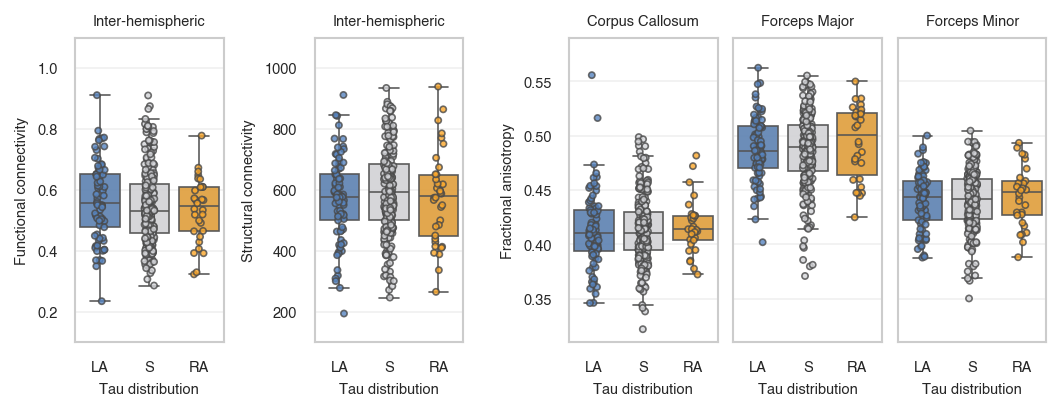

In [3]:
vars = {
    'dk_fc_file': 'Inter-hemispheric FC',
    'nan0': 'nan0',  # new spacing between FC and SC
    'dk_sc_file': 'Inter-hemispheric SC', 
    'nan1': 'nan1',  # original spacing
    'mean_FA_tq_CC_345': 'Corpus Callosum FA', 
    'mean_FA_xt_fma': 'Forceps Major FA', 
    'mean_FA_xt_fmi': 'Forceps Minor FA'
}

titles = {
    'dk_fc_file': 'Inter-hemispheric',
    'nan0': 'nan0',
    'dk_sc_file': 'Inter-hemispheric', 
    'nan1': 'nan1',
    'mean_FA_tq_CC_345': 'Corpus Callosum', 
    'mean_FA_xt_fma': 'Forceps Major', 
    'mean_FA_xt_fmi': 'Forceps Minor'
}

ylabels = {
    'dk_fc_file': 'Functional connectivity',
    'nan0': 'nan0',
    'dk_sc_file': 'Structural connectivity', 
    'nan1': 'nan1',
    'mean_FA_tq_CC_345': 'Fractional anisotropy', 
    'mean_FA_xt_fma': 'Fractional anisotropy', 
    'mean_FA_xt_fmi': 'Fractional anisotropy'
}

grp_order = ['LA', 'S', 'RA']
grp_colors = {'LA': '#5785C1FF', 'S': '#D3D4D8FF', 'RA': '#FBA72AFF'}
grp_comparisons = [('S', 'LA'), ('S', 'RA'), ('LA', 'RA')]
covars = ['age', 'gender_baseline_variable', 'tnic_global']

### plotting + stats

set_plot_style(dpi=150)
box_kwargs = dict(alpha=0.95, lw=0.8)
strip_kwargs = dict(linewidth=0.8, size=3, alpha=0.8, edgecolor='#494949')
pval_kwargs = dict(lw=0.8, fontsize=7, col='#494949', h_coef=0.015, y_coef=0.1)
fig, axs = plt.subplots(1, 7, figsize=(180/25.4, 70/25.4), 
                        gridspec_kw={'width_ratios': [2, 0.8, 2, 1, 2, 2, 2]})
axs = axs.flatten()
for i, var in enumerate(vars.keys()):
    # average inter-hemispheric FC and SC
    if 'c_file' in var:
        # set connectome and plot parameters
        if var == 'dk_fc_file': 
            m_type = f'dk_n_fc_interhemi_mask_90'
            drop_first_roi = True
            fisher = True
            replace_nan_with = None
            # ylim = [0.15, 1.0]
            ylim = [0.1, 1.1]
        elif var == 'dk_sc_file': 
            m_type = f'dk_n_sc_interhemi_mask_90'
            drop_first_roi = False
            fisher = False
            replace_nan_with = None
            # ylim = [150, 1000]
            ylim = [100, 1100]
            # axs[i] = set_scientific_formatter(axs[i], axis='y')
        axs[i].set_ylabel(ylabels[var])
        # merge connectomes and apply mask
        df_p = df_c_ts[~df_c_ts[var].isna()]
        mask = np.load(os.path.join(masks_dir, f'{m_type}.npy'))
        conn_params = dict(connectome_path_col=var, drop_first_roi=drop_first_roi, fisher=fisher, 
                           replace_nan_with=replace_nan_with, mask=mask, verbose=True)
        df_LA, c_LA = merge_connectomes(df_p[df_p[grp_col]=='LA'], **conn_params)
        df_S, c_S = merge_connectomes(df_p[df_p[grp_col]=='S'], **conn_params)
        df_RA, c_RA = merge_connectomes(df_p[df_p[grp_col]=='RA'], **conn_params)
        # calculate connectome averages and setup for plotting+stats
        data = {
            'LA': mean_nonzero(c_LA, axis=(0, 1)),
            'S': mean_nonzero(c_S, axis=(0, 1)),
            'RA': mean_nonzero(c_RA, axis=(0, 1))
        }
        dfs_covars = {'LA': df_LA, 'S': df_S, 'RA': df_RA}
    # empty plot filler for separation
    elif 'nan' in var:
        axs[i].axis('off')
        continue
    # average tract MD and FA
    else:
        # setup for plotting+stats
        # df_p = df_c_ts[~df_c_ts[var].isna()]
        df_p = df_c_ts.dropna(subset=['mean_FA_tq_CC_345', 'mean_FA_xt_fma', 'mean_FA_xt_fmi'])
        data = {
            'LA': df_p.loc[df_p[grp_col]=='LA', var].to_numpy(),
            'S': df_p.loc[df_p[grp_col]=='S', var].to_numpy(),
            'RA': df_p.loc[df_p[grp_col]=='RA', var].to_numpy()
        }
        dfs_covars = {
            'LA': df_p.loc[df_p[grp_col]=='LA'],
            'S': df_p.loc[df_p[grp_col]=='S'],
            'RA': df_p.loc[df_p[grp_col]=='RA']
        }

    # 
    combined_data = []
    for group in list(data.keys()):
        combined_data.append(pd.DataFrame({
            'Tau distribution': [group] * len(data[group]),
            vars[var]: data[group]
        }))
    df_combined = pd.concat(combined_data).reset_index(drop=True)
    print(f"\nN ({var}) = {len(df_combined)}")

    data_args = dict(ax=axs[i], x='Tau distribution', y=vars[var], data=df_combined, order=grp_order, palette=grp_colors)
    sns.boxplot(showfliers=False, **data_args)
    sns.stripplot(**data_args, **strip_kwargs)
    axs[i].set_title(titles[var])

    # set plot parameters
    if 'mean_FA' in var:
        ylim = [0.31, 0.59]
        if i==4:
            axs[i].set_ylabel(ylabels[var])
        else:
            axs[i].set_yticklabels('')
            axs[i].set_ylabel('')

    for box in axs[i].patches:
        box.set_linewidth(box_kwargs['lw'])
        box.set_alpha(box_kwargs['alpha'])
    for line in axs[i].lines:
        line.set_linewidth(box_kwargs['lw'])
        line.set_alpha(box_kwargs['alpha'])
    
    tvals, pvals, pvals_cor, models = ols_comparison(dfs_covars, data, grp_comparisons, covars=covars, posthoc='bonferroni')
    for comparison in [('S', 'LA'), ('S', 'RA')]:
        mdl = models[comparison]
        b = mdl.params['group_bin'].round(3)
        se = mdl.bse['group_bin'].round(3)
        ci = [mdl.conf_int().loc['group_bin'].iloc[0].round(3), 
            mdl.conf_int().loc['group_bin'].iloc[1].round(3)]
        pval = pvals_cor[comparison].round(3)
        print(f'{comparison}: b={b}, SE={se}, 95%CI={ci}, p_bonf={pval}')
    
    if grp_comparisons is not None and pvals_cor is not None:
        add_significance(axs[i], grp_order, grp_comparisons, pvals_cor, hide_ns=True, **pval_kwargs)
    axs[i].set_ylim(ylim)

plt.tight_layout()
plt.subplots_adjust(wspace=0.125)
plt.savefig(os.path.join(plot_dir, 'avg_connectivity.pdf'), format='pdf', dpi=300)
plt.show()

In [22]:
# vars = {'dk_fc_file': 'FC', 'dk_sc_file': 'SC', 'dk_fa_file': 'FA', 'dk_md_file': 'MD'}
vars = {'dk_fc_file': 'FC', 'dk_sc_file': 'SC'}
grp_order = ['LA', 'S', 'RA']
grp_colors = {'LA': '#5785C1FF', 'S': '#D3D4D8FF', 'RA': '#FBA72AFF'}
grp_comparisons = [('S', 'LA'), ('S', 'RA')]
covars = ['age', 'gender_baseline_variable', 'tnic_cho_com_I_VI']

# dk_img, dk_labels, dk_coords = fetch_dk_atlas(coords=True)

tvals, pvals, pvals_fdr = {}, {}, {}
for i, var in enumerate(vars.keys()):
    for comparison in grp_comparisons:
        print(vars[var], comparison)
        # set connectome parameters
        if var == 'dk_fc_file': 
            m_type = f'dk_n_fc_interhemi_mask_90'
            drop_first_roi = True
            fisher = True
            replace_nan_with = None
        elif var == 'dk_sc_file': 
            m_type = f'dk_n_sc_interhemi_mask_90'
            drop_first_roi = False
            fisher = False
            replace_nan_with = None

        # merge connectomes and apply mask
        df_p = df_c_ts[~df_c_ts[var].isna()]
        mask = np.load(os.path.join(masks_dir, f'{m_type}.npy'))
        # mask = get_dk_hemisphere_mask(dk_labels, type='interhemi_pairs')
        conn_params = dict(connectome_path_col=var, drop_first_roi=drop_first_roi, fisher=fisher, 
                            replace_nan_with=replace_nan_with, mask=mask, verbose=True)
        df_LA, c_LA = merge_connectomes(df_p[df_p[grp_col]=='LA'], **conn_params)
        df_S, c_S = merge_connectomes(df_p[df_p[grp_col]=='S'], **conn_params)
        df_RA, c_RA = merge_connectomes(df_p[df_p[grp_col]=='RA'], **conn_params)

        # setup for plotting+stats
        data = {'LA': c_LA, 'S': c_S, 'RA': c_RA}
        dfs_covars = {'LA': df_LA, 'S': df_S, 'RA': df_RA}

        _tvals, _pvals, _pvals_fdr = ols_matrix_comparison(dfs_covars, data, comparison, covars=covars, posthoc='fdr_bh')
        print(f"n of p-vals<0.05 = {len(_pvals[_pvals<0.05])}/{len(_pvals[~np.isnan(_pvals)])} (min p-val = {np.min(_pvals[~np.isnan(_pvals)])})")
        print(f"n of p-vals(FDR)<0.05 = {len(_pvals_fdr[_pvals_fdr<0.05])}/{len(_pvals_fdr[~np.isnan(_pvals_fdr)])} (min p-val(FDR) = {np.min(_pvals_fdr[~np.isnan(_pvals_fdr)])})")
        tvals[var, comparison], pvals[var, comparison], pvals_fdr[var, comparison] = _tvals, _pvals, _pvals_fdr

FC ('S', 'LA')
n of p-vals<0.05 = 72/1412 (min p-val = 0.00044593389136262675)
n of p-vals(FDR)<0.05 = 0/1412 (min p-val(FDR) = 0.31482932730201446)
FC ('S', 'RA')
n of p-vals<0.05 = 136/1412 (min p-val = 0.0003577293856834349)
n of p-vals(FDR)<0.05 = 0/1412 (min p-val(FDR) = 0.21126378229339604)
SC ('S', 'LA')
n of p-vals<0.05 = 82/1412 (min p-val = 0.00030542753437783933)
n of p-vals(FDR)<0.05 = 0/1412 (min p-val(FDR) = 0.21563183927075455)
SC ('S', 'RA')
n of p-vals<0.05 = 120/1412 (min p-val = 0.0012085148464279606)
n of p-vals(FDR)<0.05 = 0/1412 (min p-val(FDR) = 0.420504133585628)


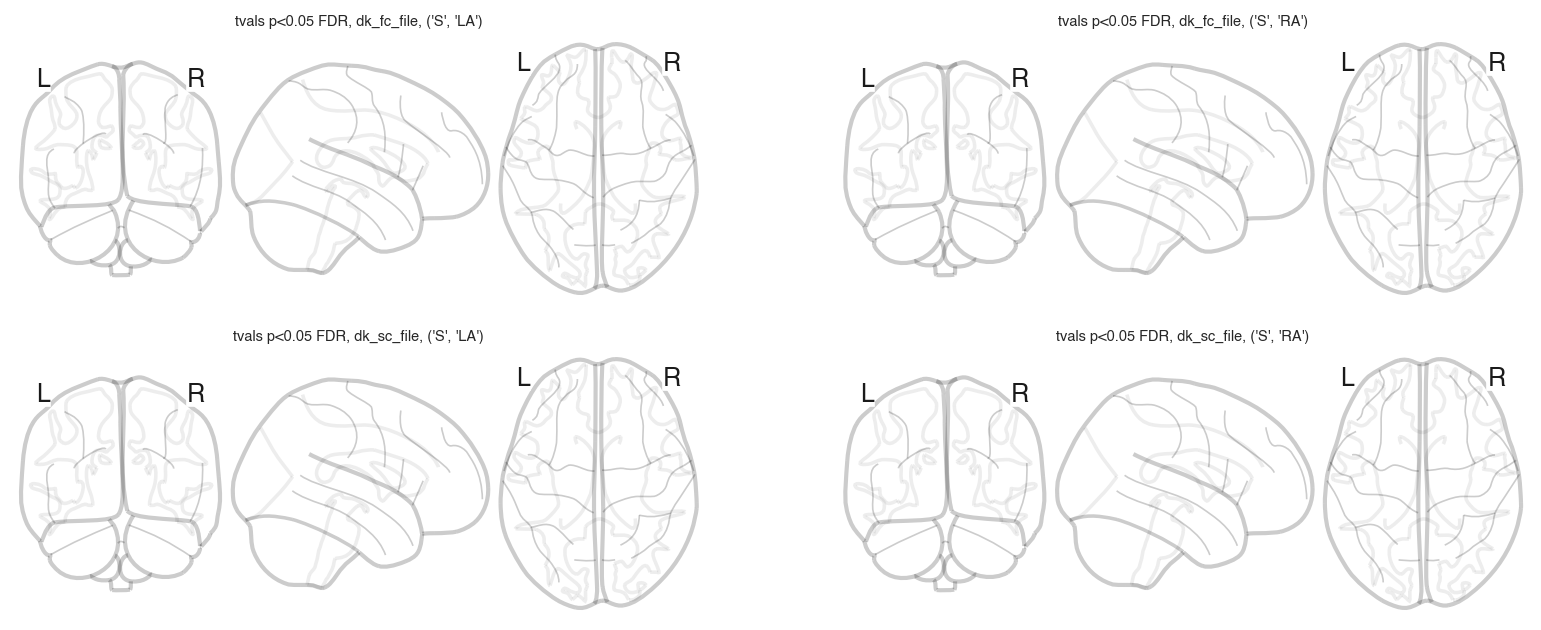

In [24]:
_, _, dk_coords = fetch_dk_atlas(coords=True)

connplot_kwargs = dict(alpha=0.2, node_color='#424242', edge_kwargs=dict(linewidth=1.5))

fig, axs = plt.subplots(2, 2, figsize=(13, 5))
for i, var in enumerate(vars.keys()):
    for j, comparison in enumerate(grp_comparisons):

        # FDR-corrected t-vals
        mat = np.where(pvals_fdr[var, comparison]<0.05, tvals[var, comparison], 0)

        # node size
        nd_str = np.nansum(np.abs(mat), axis=0)
        if np.max(nd_str) != 0:
            nd_size = nd_str / np.max(nd_str) * 10
        else:
            nd_size = 0

        plot_connectome(mat, node_coords=dk_coords, **connplot_kwargs, node_size=nd_size, axes=axs[i, j])
        axs[i, j].set_title(f'tvals p<0.05 FDR, {var}, {comparison}')
plt.show()

##### Figure S2.1 - MD


N (mean_MD_tq_CC_345) = 336
('S', 'LA'): b=-0.065, SE=0.125, 95%CI=[-0.311, 0.181], p_bonf=1.0
('S', 'RA'): b=0.04, SE=0.187, 95%CI=[-0.329, 0.408], p_bonf=1.0

N (mean_MD_xt_fma) = 336
('S', 'LA'): b=-0.013, SE=0.128, 95%CI=[-0.264, 0.238], p_bonf=1.0
('S', 'RA'): b=0.21, SE=0.187, 95%CI=[-0.159, 0.578], p_bonf=0.79

N (mean_MD_xt_fmi) = 336
('S', 'LA'): b=0.112, SE=0.127, 95%CI=[-0.137, 0.361], p_bonf=1.0
('S', 'RA'): b=0.148, SE=0.189, 95%CI=[-0.223, 0.52], p_bonf=1.0


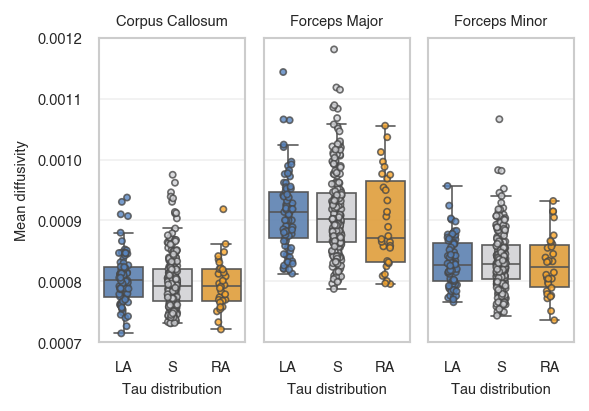

In [14]:
vars = {
    'mean_MD_tq_CC_345': 'Corpus Callosum MD', 
    'mean_MD_xt_fma': 'Forceps Major MD', 
    'mean_MD_xt_fmi': 'Forceps Minor MD'
}

titles = {
    'mean_MD_tq_CC_345': 'Corpus Callosum', 
    'mean_MD_xt_fma': 'Forceps Major', 
    'mean_MD_xt_fmi': 'Forceps Minor'
}

ylabels = {
    'mean_MD_tq_CC_345': 'Mean diffusivity', 
    'mean_MD_xt_fma': 'Mean diffusivity', 
    'mean_MD_xt_fmi': 'Mean diffusivity'
}

grp_order = ['LA', 'S', 'RA']
grp_colors = {'LA': '#5785C1FF', 'S': '#D3D4D8FF', 'RA': '#FBA72AFF'}
grp_comparisons = [('S', 'LA'), ('S', 'RA'), ('LA', 'RA')]
covars = ['age', 'gender_baseline_variable', 'tnic_global']

### plotting + stats

set_plot_style(dpi=150)
box_kwargs = dict(alpha=0.95, lw=0.8)
strip_kwargs = dict(linewidth=0.8, size=3, alpha=0.8, edgecolor='#494949')
pval_kwargs = dict(lw=0.8, fontsize=7, col='#494949', h_coef=0.015, y_coef=0.1)
fig, axs = plt.subplots(1, 3, figsize=(100/25.4, 70/25.4))
axs = axs.flatten()
for i, var in enumerate(vars.keys()):

    # setup for plotting+stats
    # df_p = df_c_ts[~df_c_ts[var].isna()]
    df_p = df_c_ts.dropna(subset=['mean_MD_tq_CC_345', 'mean_MD_xt_fma', 'mean_MD_xt_fmi'])
    data = {
        'LA': df_p.loc[df_p[grp_col]=='LA', var].to_numpy(),
        'S': df_p.loc[df_p[grp_col]=='S', var].to_numpy(),
        'RA': df_p.loc[df_p[grp_col]=='RA', var].to_numpy()
    }
    dfs_covars = {
        'LA': df_p.loc[df_p[grp_col]=='LA'],
        'S': df_p.loc[df_p[grp_col]=='S'],
        'RA': df_p.loc[df_p[grp_col]=='RA']
    }

    # 
    combined_data = []
    for group in list(data.keys()):
        combined_data.append(pd.DataFrame({
            'Tau distribution': [group] * len(data[group]),
            vars[var]: data[group]
        }))
    df_combined = pd.concat(combined_data).reset_index(drop=True)
    print(f"\nN ({var}) = {len(df_combined)}")

    data_args = dict(ax=axs[i], x='Tau distribution', y=vars[var], data=df_combined, order=grp_order, palette=grp_colors)
    sns.boxplot(showfliers=False, **data_args)
    sns.stripplot(**data_args, **strip_kwargs)
    axs[i].set_title(titles[var])

    # set plot parameters
    if 'mean_MD' in var:
        ylim = [0.0007, 0.0012]
        if i==0:
            axs[i].set_ylabel(ylabels[var])
        else:
            axs[i].set_yticklabels('')
            axs[i].set_ylabel('')

    for box in axs[i].patches:
        box.set_linewidth(box_kwargs['lw'])
        box.set_alpha(box_kwargs['alpha'])
    for line in axs[i].lines:
        line.set_linewidth(box_kwargs['lw'])
        line.set_alpha(box_kwargs['alpha'])
    
    tvals, pvals, pvals_cor, models = ols_comparison(dfs_covars, data, grp_comparisons, covars=covars, posthoc='bonferroni')
    for comparison in [('S', 'LA'), ('S', 'RA')]:
        mdl = models[comparison]
        b = mdl.params['group_bin'].round(3)
        se = mdl.bse['group_bin'].round(3)
        ci = [mdl.conf_int().loc['group_bin'].iloc[0].round(3), 
            mdl.conf_int().loc['group_bin'].iloc[1].round(3)]
        pval = pvals_cor[comparison].round(3)
        print(f'{comparison}: b={b}, SE={se}, 95%CI={ci}, p_bonf={pval}')
    
    if grp_comparisons is not None and pvals_cor is not None:
        add_significance(axs[i], grp_order, grp_comparisons, pvals_cor, hide_ns=True, **pval_kwargs)
    axs[i].set_ylim(ylim)

plt.tight_layout()
plt.subplots_adjust(wspace=0.125)
plt.savefig(os.path.join(plot_dir, 'suppl_avg_md.pdf'), format='pdf', dpi=300)
plt.show()